In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### 生成股票数据

In [3]:
class StockGenerator:
    @staticmethod
    def gaussian(num_samples, mean=100, std_dev=12):
        """
        生成高斯分布的股票数据。

        参数：
        num_samples: 生成的样本数量
        mean: 均值
        std_dev: 标准差

        返回：
        包含随机生成数据的NumPy数组
        """
        # 生成正态分布的数据
        data = np.random.normal(mean, std_dev, num_samples)

        return data

    @staticmethod
    def brownian(num_samples, init_price=100, drift=0.05, volatility=0.2, time_interval=1):
        """
        生成布朗运动版本的股票价格数据。

        参数：
        num_samples: 生成的样本数量
        init_price: 初始股票价格，默认值为100
        drift: 股票价格的漂移，默认值为0.05
        volatility: 股票价格的波动率，默认值为0.2
        time_interval: 时间间隔，默认值为1

        返回：
        包含随机生成数据的NumPy数组
        """
        # 生成时间序列
        t = np.linspace(0, time_interval, num_samples)

        # 生成随机项
        rand = np.random.normal(0, 1, num_samples)

        # 计算布朗运动
        price = init_price * np.exp((drift - 0.5 * volatility**2) * t + volatility * np.sqrt(t) * rand)

        return price

In [4]:
generator = StockGenerator()

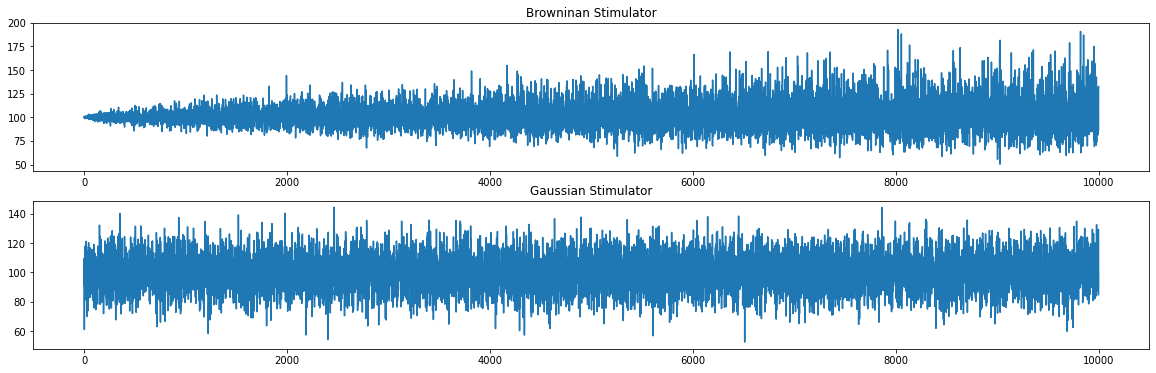

In [9]:
plt.figure(figsize=(20, 6))

num_samples = 10000
plt.subplot(2, 1, 1)
plt.plot(range(num_samples), generator.brownian(num_samples))
plt.title('Browninan Stimulator')

plt.subplot(2, 1, 2)
plt.plot(range(num_samples), generator.gaussian(num_samples))
plt.title('Gaussian Stimulator')
plt.show()

####  最终我们选择布朗运动，因为布朗运动更符合我们对于股票模拟的要求

### 建立股票操作环境类
我们需要定义的行为如下：
1. 用户操作 -- 买入，卖出，持有
2. 记录操作后果 -- 记录用户操作造成的资金变化
3. ...

In [10]:
import random

User ending fund:  141.11701891695387


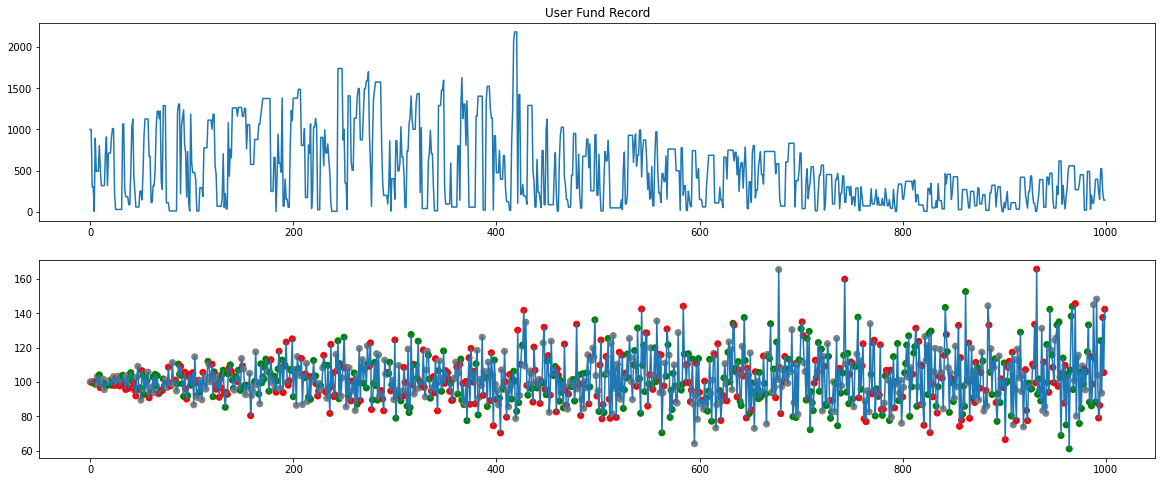

In [13]:
# 使用一个loop自动模拟用户操作
user_fund = 1000
user_stocks = 0
available_operations = ['buy', 'sold', 'hold']
operation_map = dict(zip(available_operations, [i for i in range(3)]))
user_fund_record = []
user_op_record = []

stock_prices = generator.brownian(1000)
for idx, current_price in enumerate(stock_prices):
    if user_fund < 0:
        print(f'User bankrupt at day {idx+1} ! : {user_fund}')
        break
    user_current_op = random.choice(available_operations)
    
    if user_current_op == 'buy':
        if user_fund >= current_price:
            # buy random amount of stocks
            buy_amount = random.randint(1, user_fund // current_price)
            # update user fund and stock amount
            user_fund -= buy_amount * current_price
            user_stocks += buy_amount

    elif user_current_op == 'sold':
        if user_stocks > 0:
            # sold random amount of stocks
            sold_amount = random.randint(1, user_stocks)
            # update user fund and stock amount 
            user_fund += sold_amount * current_price
            user_stocks -= sold_amount
            
    elif user_current_op == 'hold':
        # as 'hold' means do nothing
        pass
    # record user current fund
    user_fund_record.append(user_fund)
    user_op_record.append(user_current_op)
    
print('User ending fund: ', user_fund)

plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.plot(user_fund_record)
plt.title('User Fund Record')

plt.subplot(2, 1, 2)
# 定义颜色映射
color_map = {'buy': 'red', 'sold': 'green', 'hold': 'gray'}

# 绘制股票价格图
plt.plot(stock_prices)

# 根据用户操作为每个数据点上色
colors = [color_map[action] for action in user_op_record]
plt.scatter(range(len(stock_prices)), stock_prices, c=colors)

plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
# 需要进行scaling避免overflow
def softmin(x):
    scaler = StandardScaler()
    x = [-i for i in x]
    x = np.reshape(x, [-1, 1])
    x = scaler.fit_transform(x)
    
    return np.exp(x) / np.sum(np.exp(x))

def softmax(x):
    scaler = StandardScaler()
    x = np.reshape(x, [-1, 1])
    x = scaler.fit_transform(x)
    
    return np.exp(x) / np.sum(np.exp(x))

In [16]:
softmax(stock_prices[:10]), stock_prices[:10]

(array([[0.04231344],
        [0.05079342],
        [0.03589231],
        [0.04936578],
        [0.02949043],
        [0.02059011],
        [0.05588296],
        [0.25574214],
        [0.01523307],
        [0.44469633]]),
 array([100.        , 100.32447446,  99.70764244, 100.27383154,
         99.35866258,  98.72049442, 100.49410469, 103.19579827,
         98.18520021, 104.17852321]))

### 我们真正的难点在于对于”低买高卖“的定义

#### 定义 1：
1. 根据当天股价以及之前n天的股价，判断当天股价属于`当前最低`，则我们认为当天能够购入股票
2. 当用户在`当前最低`时刻购入股票，我们给出的reward公式为:

$\large reward = cll_n \cdot in$

$x$是当天+n-1天之前的股价 \
$in$是购入数量 \
$cll$是confidence level局部最低可靠性，范围[0, 1]，$cll = softmin(x)$

3. 同理，对于`当前最高`的reward，公式如下：

$\large reward = clh_n \cdot x_n \cdot out$

$out$是卖出数量 \
$clh$是confidence level局部最高可靠性，范围[0, 1]，$clh = softmax(x)$


3. 以上假设没有考虑`用户持仓价值`，更新公式如下：

$\large reward = clh_n \cdot (x_n - h_{mean}) \cdot out$

$nh$是持仓数量 \
$in val$是持仓价值，也就是花了多少买的这些股票 \
$h_{mean}$是hold_mean用户持仓平均价值，$h_{mean} = \frac{nh}{in val}$

如果卖出时发生了亏损（低于持仓平均价值卖出），那样reward将会变为负数

In [143]:
"""
对于该类我们给出了以下操作者假设：
1. done的时候不能再调用该类的方法
"""
class StockStimulatorEnv(StockGenerator):
    def __init__(self, initial_fund=1000, day_limit=1000, buy_ratio=0.5, random_seed=None):
        super().__init__()
        if random_seed:
            # 固定生成结果
            np.random.seed(random_seed)
        
        self.fund = initial_fund
        self.user_stocks = 0
        self.day_limit = day_limit
        self.current_day = 0   # in index format
        self.stock_prices = self.gaussian(self.day_limit)
        
        # 定义行为维度和状态维度
        self.action_dim = 3
        self.state_dim = 1
        
        # 进行reward计算时使用的前n天天数
        self.max_days_before = 100
        
        # 禁止梭哈 -- 用户不管设置多大都只能到0.9
        self.buy_ratio = min(buy_ratio, 0.9)
        
        # 记录操作者持仓数据
        self.hold_record = {'num_hold': 0, 'in_value': 0, 'mean_in_value': 0}
   
    def reset(self):
        self.fund = 0
        self.current_day = 0
        return self.fund, self.current_day
    
    def step(self, action):
        current_price = self.stock_prices[self.current_day]
        if self.fund < 0 or (self.fund < current_price and self.user_stocks == 0):
            done = True
            reward = 0
            return self.current_day, reward, done, {'end_reason': f'bankrupt: fund = {self.fund}'}
        if action == 0:
            if self.fund > current_price:
                # buy random amount of stocks
                min_in = max(1, (int(self.buy_ratio * self.fund) // current_price))
                buy_amount = random.randint(1, min_in)
                # update user fund and stock amount
                self.fund -= buy_amount * current_price
                self.user_stocks += buy_amount
                
                # 根据定义1给出reward
                x_prices = self.stock_prices[max(0, self.current_day-self.max_days_before):self.current_day+1]   # 前n天到当前价格
                cl_low = softmin(x_prices)
                reward = float(cl_low[-1] * buy_amount)
                
                # 更新持仓数据
                self.hold_record['num_hold'] = self.user_stocks
                self.hold_record['in_value'] += buy_amount * current_price
                self.hold_record['mean_in_value'] = self.user_stocks / self.hold_record['in_value']
            else:
                reward = 0

        elif action == 1:
            if self.user_stocks > 0:
                # sold random amount of stocks
                sold_amount = random.randint(1, self.user_stocks)
                # update user fund and stock amount 
                self.fund += sold_amount * current_price
                self.user_stocks -= sold_amount
                
                # 根据定义1给出reward
                x_prices = self.stock_prices[max(0, self.current_day-self.max_days_before):self.current_day+1]   # 前n天到当前价格
#                 print(x_prices)
                cl_high = softmax(x_prices)
                
                hold_mean = self.hold_record['mean_in_value']
                reward = float(cl_high[-1] * (current_price - hold_mean) * sold_amount)
                
                # 更新持仓数据
                self.hold_record['num_hold'] = self.user_stocks
                self.hold_record['in_value'] -= hold_mean * sold_amount   # 扣除原来持仓的价值
                self.hold_record['mean_in_value'] = self.user_stocks / self.hold_record['in_value']
            else:   
                reward = 0

        elif action == 2:
            reward = 0
        
        self.current_day += 1
        done = self.current_day >= self.day_limit or self.fund < 0
        return self.current_day, reward, done, {}

In [147]:
# 测试能不能用
day_limit = 1000
env = StockStimulatorEnv(day_limit=day_limit, random_seed=2)

# 初始化action概率分布
action_probs = np.ones(env.action_dim) / env.action_dim
alpha = 1

action = np.random.choice(env.action_dim, p=action_probs)

print(action)
print(env.step(action))

2
(1, 0, False, {})


### 实现最基本的“学习”

User ending fund:  2076.8992049525905


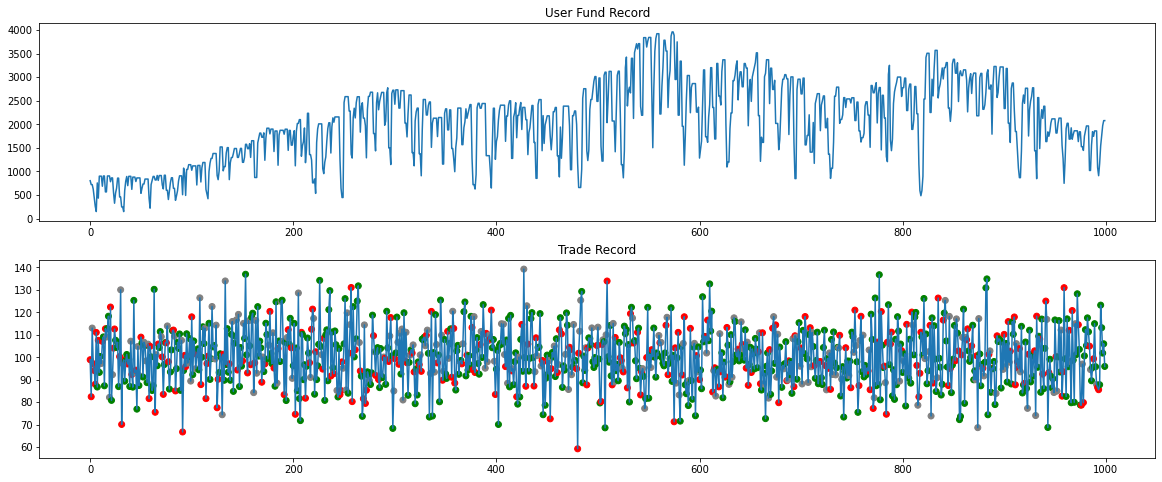

In [150]:
# 实例化环境类
day_limit = 1000
env = StockStimulatorEnv(day_limit=day_limit, random_seed=22)
stock_prices = env.stock_prices
# 初始化action概率分布
action_probs = np.ones(env.action_dim) / env.action_dim
alpha = 1

user_fund_record = []
user_op_record = []
reward_record = []

done = None
info = dict()
for i in range(1000):
    if done:
        end_reason = info.get('end_reason', '')
        if end_reason:
            print(info)
        else:
            print('Day limit reached.')
        break

    # choose random action(with biased probs)
    current_action = np.random.choice(env.action_dim, p=action_probs)

    current_day, reward, done, info = env.step(current_action)

    # 根据reward值调整概率分布
    action_probs[current_action] = action_probs[current_action] + alpha * (reward - action_probs[current_action])
    action_probs = softmax(action_probs).reshape(-1)

    # record user current fund
    user_fund_record.append(env.fund)
    user_op_record.append(current_action)
    reward_record.append(reward)

print('User ending fund: ', env.fund)

plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.plot(user_fund_record)
plt.title('User Fund Record')

plt.subplot(2, 1, 2)
# 定义颜色映射
color_map = {0: 'red', 1: 'green', 2: 'gray'}

# 绘制股票价格图
plt.plot(stock_prices)

# 根据用户操作为每个数据点上色
colors = [color_map[action] for action in user_op_record]
plt.scatter(range(len(stock_prices)), stock_prices, c=colors)
plt.title('Trade Record')

plt.show()

### 变为函数形式

In [118]:
def trading_agent(initial_fund=1000, day_limit=1000, buy_ratio=0.5):
    # 实例化环境类
    env = StockStimulatorEnv(initial_fund=initial_fund, day_limit=day_limit, buy_ratio=buy_ratio)
    stock_prices = env.stock_prices
    # 初始化action概率分布
    action_probs = np.ones(env.action_dim) / env.action_dim
    alpha = 1

    user_fund_record = []
    user_op_record = []
    reward_record = []

    done = None
    info = dict()
    for i in range(day_limit):
        if done:
            end_reason = info.get('end_reason', '')
            if end_reason:
                print(info)
            else:
                print('Day limit reached.')
            break

        # choose random action(with biased probs)
        current_action = np.random.choice(env.action_dim, p=action_probs)

        current_day, reward, done, info = env.step(current_action)

        # 根据reward值调整概率分布
        action_probs[current_action] = action_probs[current_action] + alpha * (reward - action_probs[current_action])
        action_probs = softmax(action_probs).reshape(-1)

        # record user current fund
        user_fund_record.append(env.fund)
        user_op_record.append(current_action)
        reward_record.append(reward)

#     print('User ending fund: ', env.fund)
    return env.fund, action_probs, user_fund_record, user_op_record, reward_record

In [100]:
end_fund, action_probs, _, _, _ = trading_agent()
end_fund, action_probs

(5803.174062000471, array([0.09254749, 0.80623906, 0.10121345]))

In [111]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

In [120]:
end_funds = []
for i in tqdm(range(100)):
    end_fund, _, _, _, _ = trading_agent()
    end_funds.append(end_fund)

START_FUND = 1000
mean_growth = '{:.2f} %'.format(((np.mean(end_funds) - START_FUND) / START_FUND) * 100)   # x % from original fund
median_growth = '{:.2f} %'.format(((np.median(end_funds) - START_FUND) / START_FUND) * 100)
print(f'Mean fund growth: {mean_growth}')
print(f'Median fund growth: {median_growth}')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.69it/s]

Mean fund growth: 107.80 %
Median fund growth: 43.98 %


#### metrics for the bot

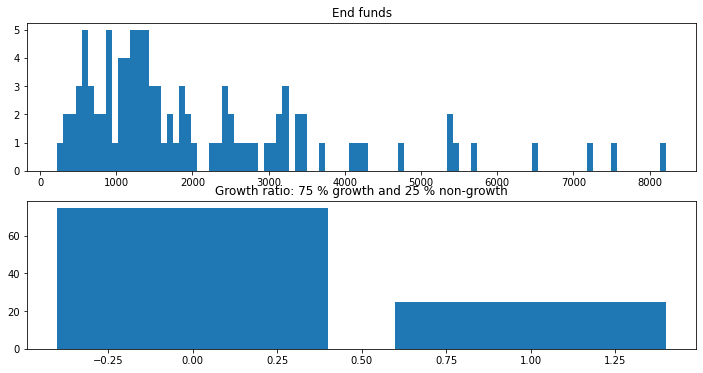

In [121]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.hist(end_funds, bins=100)
plt.title('End funds')

plt.subplot(2, 1, 2)
fund_growth_list = [1 if i > START_FUND else 0 for i in end_funds]
growth_count = sum(fund_growth_list)
non_growth_count = len(end_funds) - growth_count
plt.bar([0, 1], [growth_count, non_growth_count])
plt.title(f'Growth ratio: {growth_count} % growth and {non_growth_count} % non-growth')

plt.show()